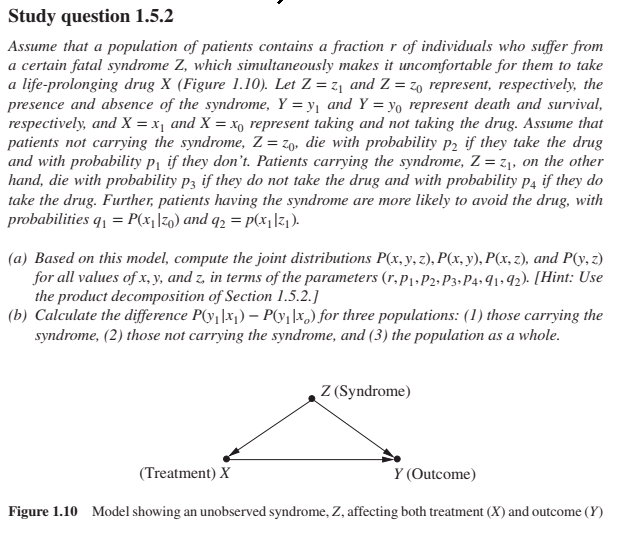

### 3.2.1 &mdash; problem statement
Referring to study question 1.5.2 (figure 1.10) and the parameters listed therein:

(a) Compute $P(y|do(x))$ for all $x$ and $y$ by simulating the intervention $do(x)$ on the model. <br/>
(b) Compute $P(y|do(x)))$ for all values $x$ and $y$ by using the adjustment formula (3.5) <br/>
(c) Compute the ACE:
$$ \textrm{ACE} := P(y_1|do(x_1)) - P(y_1|do(x_0))$$
and compare it to the risk difference:
$$ \textrm{RD} := P(y_1|x_1) - P(y_1|x_0)$$
What is the difference between ACE and the RD? What values othe parameters would minimize the distance?<br/>
(d) Find a combination of parameters that exhibit Simpson's reversal (as in study question 1.5.2(c)) and show explicitly that the overall causal reversal of the drug is obtained from the desegregated data.



### 3.2.1(a)

Here $do(x)$ corresponds to having someone take the drug regardless of whether they find it uncomfortable. $y_1$ is death and $y_0$ is survival. The intervention removes the in-arrows to X, so we have a collider $X\to Y \leftarrow Z$.

Directly computing: $P(Y=y_0|do(x))$, we obtain:

In [22]:
from sympy import *
p_1, p_2, p_3, p_4, r, q_1, q_2 = symbols('p_1, p_2, p_3, p_4, r, q_1, q_2')
# p_1: P(die|wildtype,untreated)
# p_2: P(die|wildtype,treated)
# p_3: P(die|syndrome,untreated)
# p_4: P(die|syndrome,treated)
# q_1: P(treat|wildtype)
# q_2: P(treat|syndrome)

joint_dist_orig = {  # P(die, syndrome, drug)
    ('survive', 'syndrome', 'treated'): r * q_2 * (1-p_4),
    ('survive', 'wildtype', 'treated'): (1 - r) * q_1 * (1 - p_2),
    ('survive', 'syndrome', 'untreated'): r * (1-q_2) * (1-p_3),
    ('survive', 'wildtype', 'untreated'): (1 - r) * (1 - q_1) * (1 - p_1),
    ('die', 'syndrome', 'treated'): r * q_2 * p_4,
    ('die', 'wildtype', 'treated'): (1-r) * q_1 * p_2,
    ('die', 'syndrome', 'untreated'): r * (1-q_2) * p_3,
    ('die', 'wildtype', 'untreated'): (1 - r) * (1-q_1) * p_1,
}

## Direct computation
joint_dist_do_treat = {
    ('survive', 'syndrome'): r * (1-p_4),
    ('survive', 'wildtype'): (1 - r) * (1 - p_2),
    ('die', 'syndrome'): r * p_4,
    ('die', 'wildtype'): (1-r) * p_2,
}
joint_dist_do_untreat = {
    ('survive', 'syndrome'): r * (1-p_3),
    ('survive', 'wildtype'): (1 - r) * (1 - p_1),
    ('die', 'syndrome'): r * p_3,
    ('die', 'wildtype'): (1 - r) * p_1,
}

### 3.2.1 (b)
The adjustment formula says that:
$$ P(Y=y|do(X=x)) = \sum_z P(Y=y|X=x, Z=z)P(Z=z) $$

(_aside_) Question: Does $z$ range include $Y$ and $X$?

Assume not. Then the sum runs over $Z=\{\textrm{syndrome}, \textrm{wildtype}\}$. 

As an example, compute $P(\textrm{die}|do(\textrm{treatment}))$:


\begin{align}
P(\textrm{die}|do(\textrm{treatment})) &= \sum_{z\in \{\textrm{syndrome}, \textrm{wildtype}\}} P(\textrm{die}|\textrm{treatment}, Z=z)P(Z=z) \\
 &= P(\textrm{die}|\textrm{treatment}, \textrm{syndrome})P(\textrm{syndrome}) + P(\textrm{die}|\textrm{treatment}, \textrm{wildtype})P(\textrm{wildtype})\\
 &= p_4 r + p_2 (1-r)
\end{align}

In [19]:
from typing import *
def intervene_using_adjustment_formula(intervention: tuple, joint_dist: Dict[tuple, Expr]) -> Dict[tuple, Expr]:
    """
    intervention is a tuple of either None (this variable was not intervened upon) or
    non-null variables (indicating an intervention was performed).
    """
    idx_to_intervention = {idx: val for idx, val in enuemrate(intervention) if val is not None}
    

    
def conditional(vals: tuple, joint_dist: Dict[tuple, Expr]) -> Dict[tuple, Expr]:
    idx_to_val = {idx: val for idx, val in enumerate(vals) if val is not None}
    conditional_dist = {
        tuple([e for i, e in enumerate(event) if i not in idx_to_val]): 0
        for event in joint_dist
    }
    for event, prob in joint_dist.items():
        if all((e == v or v is None) for e, v in zip(event, vals)):
            conditioned_event = tuple([e for i, e in enumerate(event) if i not in idx_to_val])
            assert conditioned_event in conditional_dist
            conditional_dist[conditioned_event] += prob
    return {k: simplify(p) for k, p in conditional_dist.items()}

{('survive', 'treated'): q_1*(p_1 - 1)*(r - 1),
 ('survive', 'untreated'): -(p_0 - 1)*(q_1 - 1)*(r - 1),
 ('die', 'treated'): p_1*q_1*(1 - r),
 ('die', 'untreated'): p_0*(q_1 - 1)*(r - 1)}

In [18]:
conditional((None, None, None), joint_dist_orig)

{('survive', 'syndrome', 'treated'): q_2*r*(1 - p_3),
 ('survive', 'wildtype', 'treated'): q_1*(p_1 - 1)*(r - 1),
 ('survive', 'syndrome', 'untreated'): r*(p_2 - 1)*(q_2 - 1),
 ('survive', 'wildtype', 'untreated'): -(p_0 - 1)*(q_1 - 1)*(r - 1),
 ('die', 'syndrome', 'treated'): p_3*q_2*r,
 ('die', 'wildtype', 'treated'): p_1*q_1*(1 - r),
 ('die', 'syndrome', 'untreated'): p_2*r*(1 - q_2),
 ('die', 'wildtype', 'untreated'): p_0*(q_1 - 1)*(r - 1)}

### 3.2.1 (c) Compute the ACE:
$$ \textrm{ACE} := P(y_1|do(x_1)) - P(y_1|do(x_0))$$
and compare it to the risk difference:
$$ \textrm{RD} := P(y_1|x_1) - P(y_1|x_0)$$


$$ P(x|y)=\sum_z P(x,z|y) $$

In [23]:
RD = ((1-r)*q_1*p_2+r*q_2*p_4) -((1-r)*(1-q_1)*p_1+r*(1-q_2)*p_3)

ACE = (p_2*(1-r) + p_4*r) - (p_1*(1-r)+p_3*r)
simplify(ACE-RD)

p_1*q_1*r - p_1*q_1 + p_2*q_1*r - p_2*q_1 - p_2*r + p_2 - p_3*q_2*r - p_4*q_2*r + p_4*r

In [32]:
subs = {
    p_1: 0.5,
    p_2: 0.444,
    p_3: 0.2,
    p_4: 0.621,
    r: 0.5,
}

In [33]:
simplify(ACE-RD).subs(subs)

-0.472*q_1 - 0.4105*q_2 + 0.5325

In [34]:
simplify(ACE-RD).subs(subs).subs({q_1: 0.25, q_2: 0.5})

0.209250000000000

In [35]:
simplify(ACE-RD).subs(subs).subs({q_1: 0.99, q_2: 0.01})

0.0611150000000000